# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [1]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

In [2]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [3]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [4]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [14]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

  0%|          | 0/121376 [00:00<?, ?it/s]

# Fit to 100/121,376 data points

In [34]:
KEndmembers = 90
NPoints = 100
NData = dataI.shape[0]
MSpectra = 2151

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [35]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()];
endMemList.remove("General")
XF = endMemMap["General"]["Postprocessed Wavelength Axis [nm]"]
F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]

/tmp/ipykernel_2856750/2821050095.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,35])


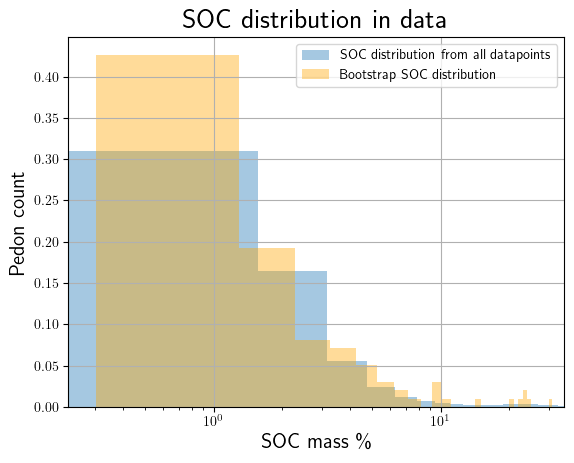

In [36]:
dataIndices = np.random.choice(NData,NPoints,replace=False)
msoc = sample_soc[dataIndices]

hist, bins = np.histogram(sample_soc, bins=50)

plt.hist(sample_soc, bins=50, density=True, alpha=0.4, label='SOC distribution from all datapoints')
plt.hist(msoc, bins=50, density=True, alpha=0.4, color='orange', label='Bootstrap SOC distribution')
plt.xlabel("SOC mass \%",fontsize=15)
plt.ylabel("Pedon count",fontsize=15)
plt.title("SOC distribution in data",fontsize=20)
plt.xscale('log')
plt.xlim([0,35])
plt.legend()
plt.grid()

del hist, bins

msoc=msoc/100.0

In [37]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

In [38]:
# generate seed alphas from seed M's, specified below from initial literature
seedMsDict = {}
def genSeedMs() :
    for endMem in endMemList :
        if "Coarse measure of average abundance" in endMemMap[endMem] :
            seedMsDict[endMem] = float(endMemMap[endMem]["Coarse measure of average abundance"])/100.
        else :
            print("\t - Mineral",endMem,"Does not have any abundance set in the JSON file.")

    # collect constant seeds from the definitions above
    seedMs = [seedMsDict[x] if x in seedMsDict else 0.0 for x in endMemList]
    seedMs = seedMs + [0.0]

    # make seedMs an N x K matrix
    seedMs = np.ones([NPoints,KEndmembers]) * seedMs
    seedMs[:,KEndmembers-1] = msoc
    seedMrem = 1.0 - np.sum(seedMs,axis=1)

    # if seedM remainder is < 0, SOC exceeds pre-defined content,
    # so rescale pre-defined values, fix SOC to prior value, and set rest to 0
    seedMNegRem = (seedMs.T * (seedMrem < 0.0).astype('float32') / np.sum(seedMs[:,:-1],axis=1) * (1.0 - msoc)).T
    seedMNegRem[:,-1] = msoc * (seedMrem < 0.0).astype('float32')
    seedMs = (seedMs.T * (seedMrem >= 0.0).astype('float32')).T + seedMNegRem
    
    # get seeds that haven't been filled in yet, excluding SOC
    # if remaining mass fraction is < 0, exclude from further partitioning
    seedMZeros = ((seedMs == 0.0).astype('float32').T * (seedMrem > 0.0).astype('float32')).T
    
    # sample random remaining seeds and renormalize to the appropriate remainder
    seedMZeros = seedMZeros * np.random.random([NPoints,KEndmembers])
    seedMZeros[:,-1] = 0.0
    
    seedMZeros = (seedMZeros.T / (np.sum(seedMZeros,axis=1)+0.00000000001)).T
    seedMrem = 1.0 - np.sum(seedMs,axis=1)
    seedMZeros = (seedMZeros.T * seedMrem).T
    seedMZeros[:,-1] = 0.0

    # add remaining seeds into seedMs
    seedMs = seedMs + seedMZeros 

    del seedMZeros, seedMrem
    
    return seedMs

seedMs = genSeedMs()

### Generate SOC seed F

In [39]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

tFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
trueFsoc = tFsoc - 0.125*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)
seedFsoc = tFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]
F = np.array(F + [seedFsoc])

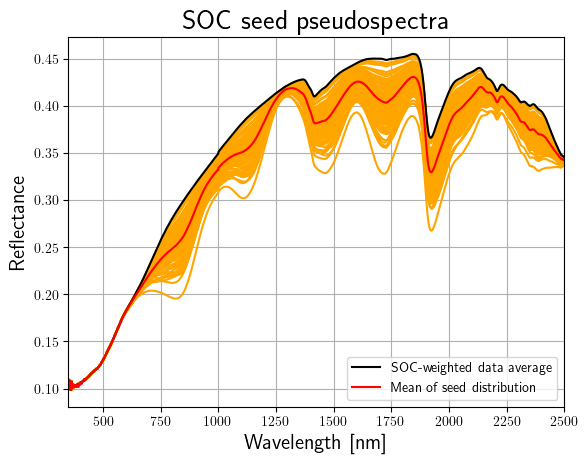

In [40]:
# Generate many seeds for comparison
seedFsocs = np.tile(tFsoc,(100,1))

for i in range(seedFsocs.shape[0]) :
    seedFsocs[i,:] = seedFsocs[i,:] - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)
    
plt.plot(XF,seedFsocs.T, 'orange')
plt.plot(XF,tFsoc.T, 'black',label="SOC-weighted data average")

plt.plot(XF,trueFsoc.T, 'red', label="Mean of seed distribution")

plt.legend()

plt.xlim([350,2500])

plt.xlabel("Wavelength [nm]",fontsize=15)
plt.ylabel("Reflectance",fontsize=15)
plt.title("SOC seed pseudospectra",fontsize=20)
plt.grid()

#plt.ylim([0,1.1])

### Generate reflectance pseudodata from mixing model

In [41]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA,axis=1)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA,axis=1)).t()

rhorads = np.array(rhos)*np.array(rads)
trueSOCrr = np.mean(rhorads)
seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
seedAs = A(seedMs,np.append(rhorads,seedSOCrr))

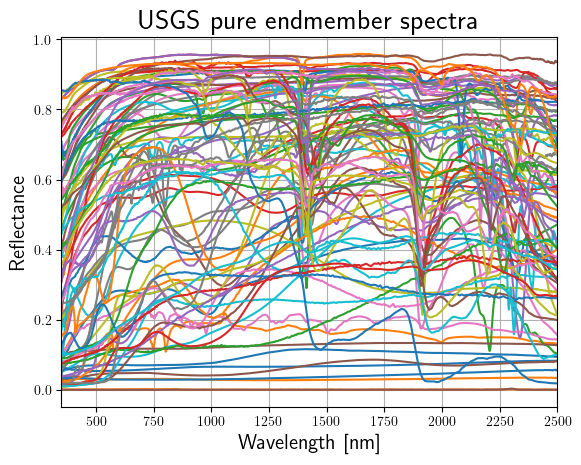

In [42]:
plt.plot(XF,F.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'USGS pure endmember spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

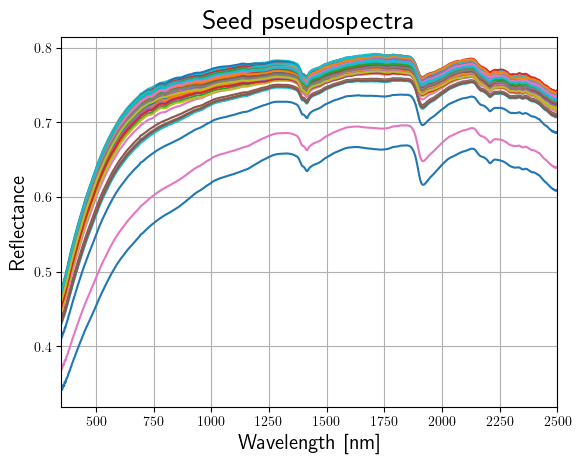

In [43]:
plt.plot(XF,np.dot(seedAs,F).T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Seed pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()
#plt.plot(XF,maxI.T,'b');

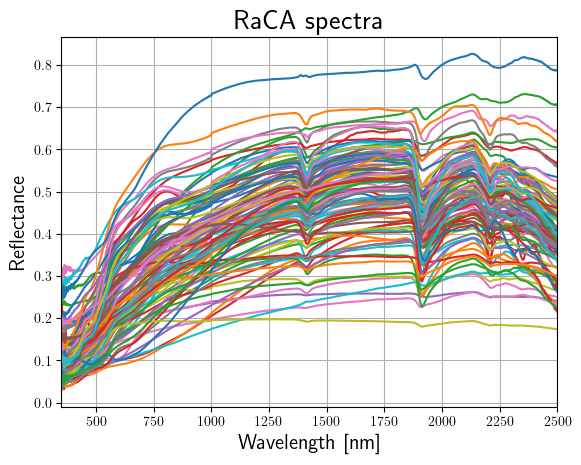

In [44]:
plt.plot(XF,dataI[dataIndices].T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'RaCA spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

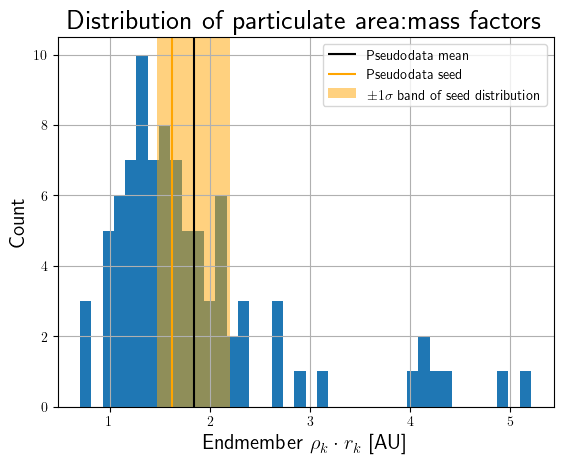

In [45]:
f, ax = plt.subplots()
th = plt.hist(rhorads,bins=40);
plt.xlabel(r'Endmember $\rho_k \cdot r_k$ [AU]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)
plt.grid()

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='black',label=r'Pseudodata mean');
plt.vlines(seedSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Pseudodata seed');
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.5,label=r'$\pm1\sigma$ band of seed distribution'));
plt.ylim([0,np.max(th[0])*1.05])
plt.legend()
plt.show()

### Run fit

In [46]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = nn.Parameter(seedrrsoc)
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.bdsFLoss = np.zeros(nepochs);
        self.omrsLoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0 and Fsoc > 1
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF) # + 10000.0*omrs
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.bdsFLoss[self.epoch] = oobsF.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss
    

In [84]:
# seed data: A[1:,:] and initial F's
tF       = torch.tensor(F[:-1,:].tolist())
tFsoc    = torch.tensor(seedFsoc.tolist())
tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
tmsoc    = torch.tensor(msoc.tolist())
trhorads = torch.tensor(rhorads.tolist())
trrsoc   = torch.tensor(seedSOCrr)

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))

nepochs = 100000
model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.95,0.9))

for epoch in tqdm(range(nepochs)) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.01 ** 2) / (NPoints*MSpectra))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.374271392822266 3.4548144340515137 0.16061433910048878


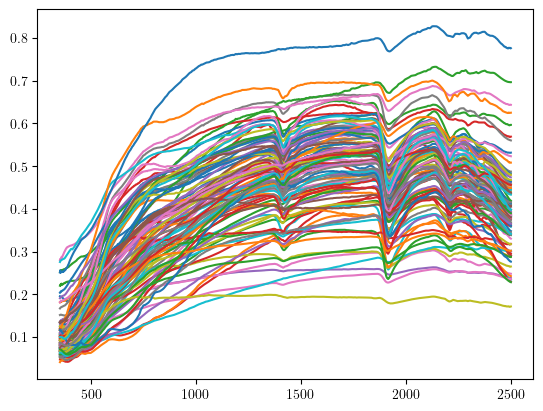

In [90]:
plt.plot(XF,model.Ihat.detach().numpy().T);

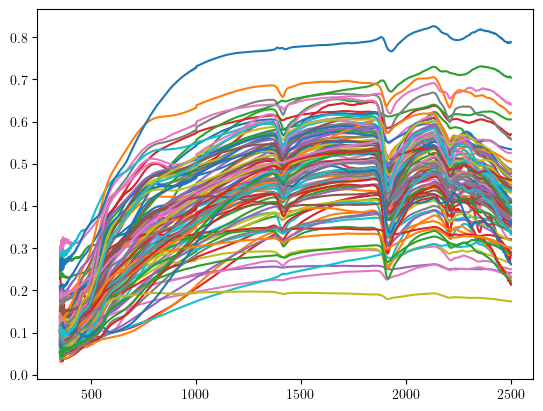

In [91]:
plt.plot(XF,dataI[dataIndices].T);

0.784228800646419 1.6222115241194968 1.8363792196655018


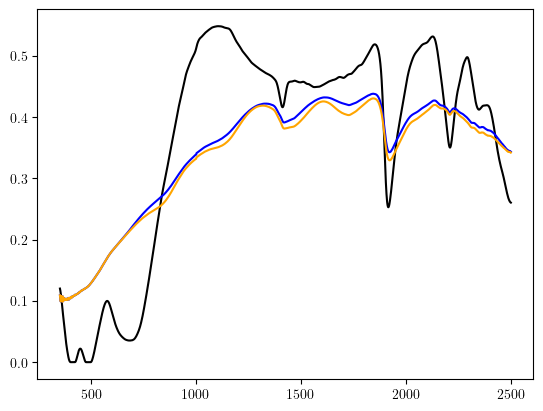

In [92]:
plt.plot(XF,model.fsoc.detach().numpy(),'black')
plt.plot(XF,seedFsoc,'blue')
plt.plot(XF,trueFsoc,'orange')
print(model.rrsoc.detach().item(),seedSOCrr[0],trueSOCrr)

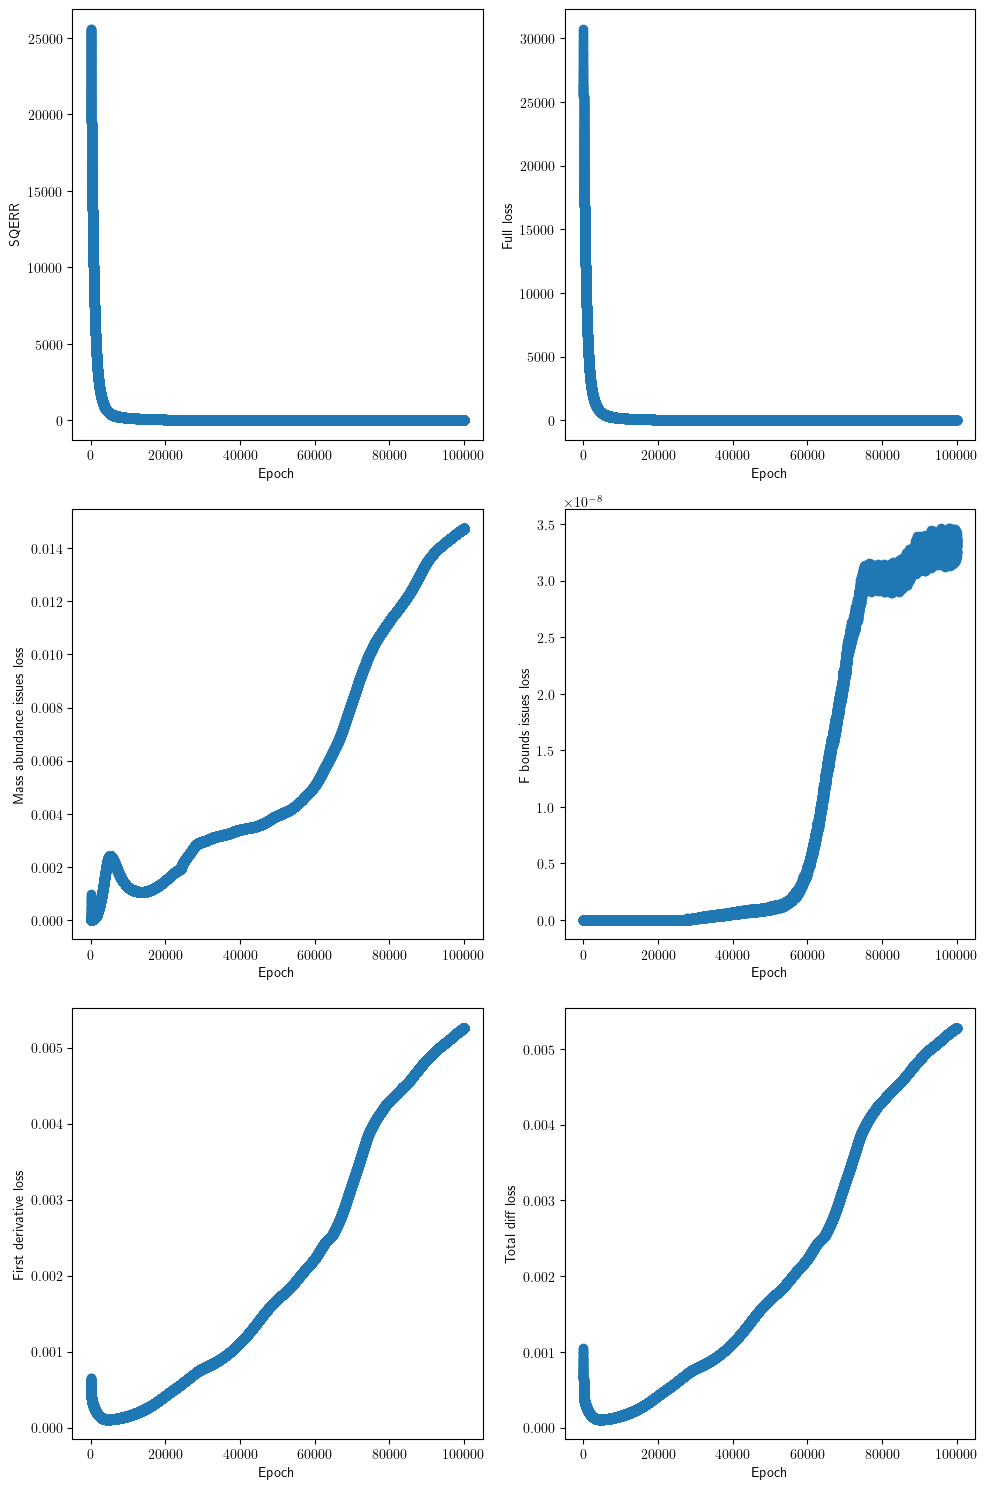

In [93]:
_, axarr = plt.subplots(3,2,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],model.lsq)
axarr[0,0].set_xlabel("Epoch")
axarr[0,0].set_ylabel("SQERR")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Full loss")

axarr[1,0].scatter([i for i in range(len(model.bdsALoss))],model.bdsALoss)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Mass abundance issues loss")

axarr[1,1].scatter([i for i in range(len(model.bdsFLoss))],model.bdsFLoss)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("F bounds issues loss")

axarr[2,0].scatter([i for i in range(len(model.diffloss1))],model.diffloss1)
axarr[2,0].set_xlabel("Epoch")
axarr[2,0].set_ylabel("First derivative loss")

axarr[2,1].scatter([i for i in range(len(model.difflossfull))],model.difflossfull)
axarr[2,1].set_xlabel("Epoch")
axarr[2,1].set_ylabel("Total diff loss")

plt.tight_layout()
plt.show()

  0%|          | 0/89 [00:00<?, ?it/s]

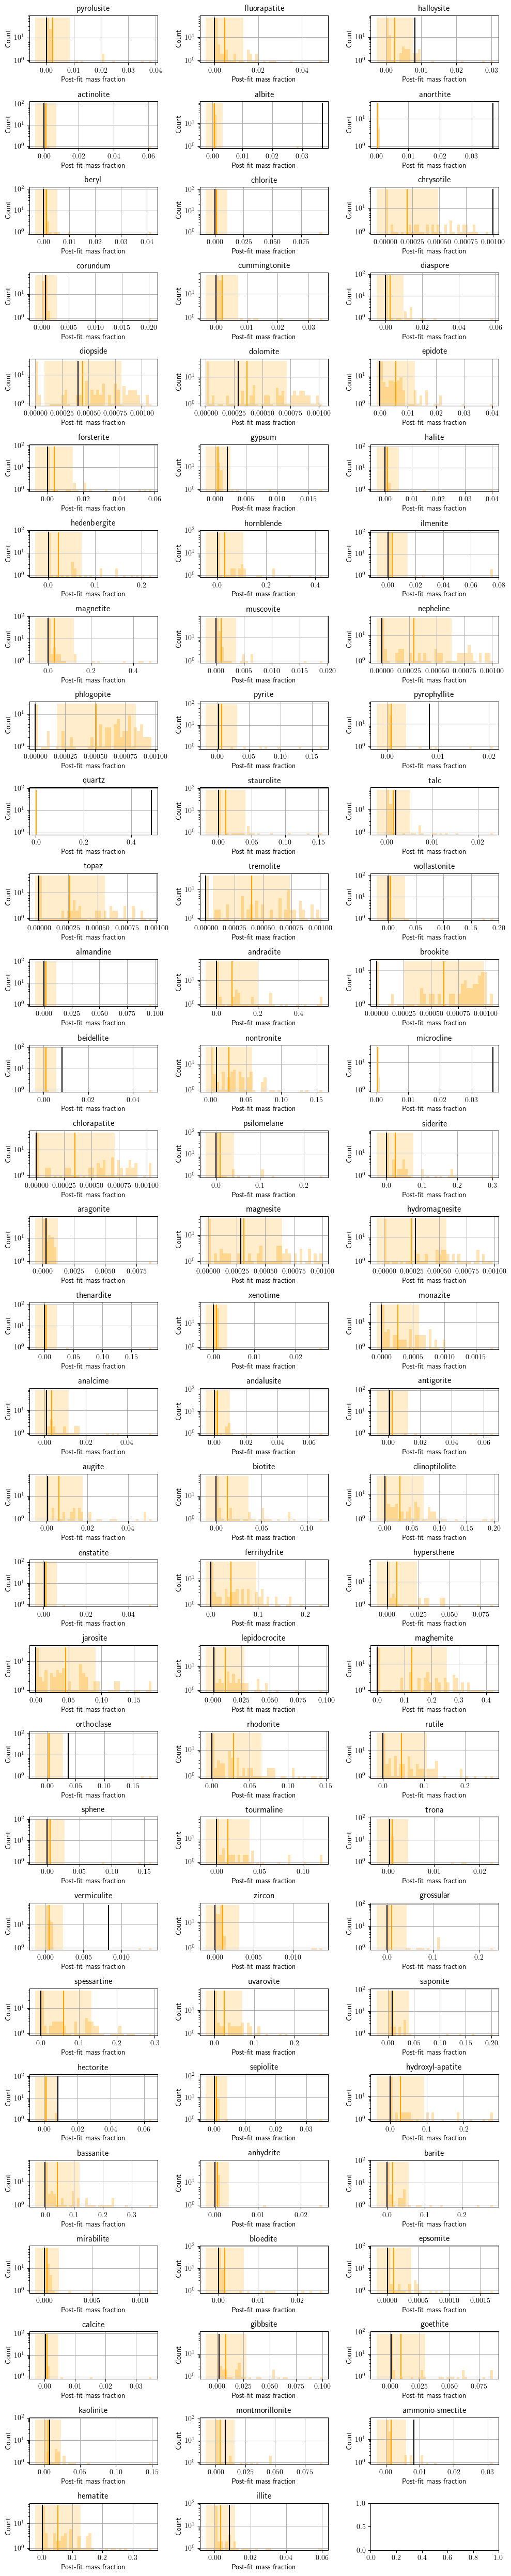

In [94]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in tqdm(range(model.ms.detach().numpy().shape[1])):

    col = index % 3
    
    tcorrms = np.array(model.ms.tolist())
    tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
    tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
    
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(tcorrms[:,iEndmember],bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(tcorrms[:,iEndmember])
    sd = np.sqrt(np.var(tcorrms[:,iEndmember]))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()

In [95]:
import pickle

with open('step2_systematics_N100_NpAll_E100k_init.pkl', 'wb') as file:
        pickle.dump((model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)

In [6]:
import pickle

with open('step2_systematics_N100_NpAll_E100k_init.pkl', 'rb') as file:
        (model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

## Serialize analysis

In [96]:
import pickle

offset = 0

for i in tqdm(range(300)) :
    
    # generate msoc
    dataIndices = np.random.choice(NData,NPoints,replace=False)
    msoc = sample_soc[dataIndices]/100.0
    
    # generate new seed Fsoc
    tempFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
    seedFsoc = tempFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

    # generate new seedMs
    seedMs = genSeedMs()
    
    # generate new seedSOCrr
    seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
    
    # convert to torch
    tF       = torch.tensor(F[:-1,:].tolist())
    tFsoc    = torch.tensor(seedFsoc.tolist())
    tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
    tmsoc    = torch.tensor(msoc.tolist())
    trhorads = torch.tensor(rhorads.tolist())
    trrsoc   = torch.tensor(seedSOCrr)
    
    # empirical data: (SOC values, reflectances, and max normalized reflectance)
    ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))
    
    # run model fit
    nepochs=100000
    model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
    optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.95,0.9))

    print("\t - Training model",i)
    for epoch in tqdm(range(nepochs)) :
        loss = model(ys)
        e = torch.mean(loss)
        e.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.05 ** 2) / (NPoints*MSpectra))
    
    with open('step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'wb') as file:
        pickle.dump((model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)
        

  0%|          | 0/300 [00:00<?, ?it/s]

	 - Training model 0


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.160950660705566 3.8863747119903564 0.00722710313712758
	 - Training model 1


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.998754501342773 5.245068073272705 0.009753729564430876
	 - Training model 2


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.134756088256836 5.020923614501953 0.009336910487218878
	 - Training model 3


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.650303840637207 5.417597770690918 0.010074565821833411
	 - Training model 4


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.598346710205078 2.3355894088745117 0.004343262499069291
	 - Training model 5


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.0442023277282715 1.4264447689056396 0.0026526169575186226
	 - Training model 6


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.49515151977539 2.4135806560516357 0.004488295036823124
	 - Training model 7


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.219924926757812 2.6336162090301514 0.004897473192059788
	 - Training model 8


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.996260643005371 3.589298725128174 0.006674660576714409
	 - Training model 9


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.370123863220215 7.6547322273254395 0.014234741473408533
	 - Training model 10


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.679905414581299 3.340259075164795 0.006211546397331092
	 - Training model 11


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.913994789123535 3.5105223655700684 0.0065281680438309024
	 - Training model 12


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.329059600830078 4.641237735748291 0.008630846556482176
	 - Training model 13


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.845627784729004 5.611106872558594 0.010434415383651497
	 - Training model 14


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.186685562133789 2.364316701889038 0.004396683778501232
	 - Training model 15


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.933487892150879 2.556419849395752 0.004753918827328222
	 - Training model 16


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.48415756225586 2.2987287044525146 0.004274716326271528
	 - Training model 17


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.898470878601074 6.522467613220215 0.012129181986462508
	 - Training model 18


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.5934247970581055 3.100236654281616 0.005765200658822158
	 - Training model 19


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.651595115661621 3.192084789276123 0.005936001467738024
	 - Training model 20


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.796483516693115 3.136026382446289 0.0058317552439726425
	 - Training model 21


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.694402694702148 2.7609939575195312 0.005134344876837807
	 - Training model 22


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.264057159423828 2.5996859073638916 0.004834376396771531
	 - Training model 23


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.07420825958252 2.469480037689209 0.0045922455373114054
	 - Training model 24


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.711814880371094 5.7656965255737305 0.01072189033114594
	 - Training model 25


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.210163116455078 6.361812591552734 0.01183042787829425
	 - Training model 26


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.513875961303711 2.0738000869750977 0.0038564390273827936
	 - Training model 27


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.369302749633789 2.8873097896575928 0.00536924182177144
	 - Training model 28


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.955733299255371 3.1317672729492188 0.005823835003159867
	 - Training model 29


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.528456687927246 4.639679908752441 0.008627949621111
	 - Training model 30


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.586316108703613 3.7871274948120117 0.007042542993606716
	 - Training model 31


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.11015796661377 3.3824586868286133 0.0062900208030285685
	 - Training model 32


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.153173446655273 2.5328497886657715 0.004710087938011661
	 - Training model 33


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.17183780670166 2.6597824096679688 0.00494613186363174
	 - Training model 34


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.026552200317383 3.050360918045044 0.005672451730441736
	 - Training model 35


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.099756240844727 3.263455629348755 0.0060687226952092135
	 - Training model 36


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.3058648109436035 1.7676395177841187 0.003287102775981624
	 - Training model 37


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.33519172668457 2.5928685665130615 0.004821698868457575
	 - Training model 38


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.139093399047852 2.8017501831054688 0.005210135161516445
	 - Training model 39


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.677471160888672 5.586092948913574 0.010387899486589629
	 - Training model 40


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.892284393310547 5.299123287200928 0.009854250650303908
	 - Training model 41


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.18401050567627 3.8739609718322754 0.007204018543621153
	 - Training model 42


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.392662048339844 2.923598051071167 0.005436723479444289
	 - Training model 43


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.062942504882812 8.376201629638672 0.015576386108114683
	 - Training model 44


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.808320045471191 2.926654815673828 0.005442407839467834
	 - Training model 45


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.6608710289001465 3.1212456226348877 0.00580426894027873
	 - Training model 46


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.763326168060303 1.8341403007507324 0.0034107676443528257
	 - Training model 47


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  20.7329044342041 13.313286781311035 0.024757390574265053
	 - Training model 48


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.961259365081787 1.7938867807388306 0.003335912191053148
	 - Training model 49


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.480341911315918 1.7060825824737549 0.003172631487631343
	 - Training model 50


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.690850734710693 1.8147777318954468 0.003374761007708873
	 - Training model 51


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.84852123260498 3.281569480895996 0.006102407216914915
	 - Training model 52


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  4.940123558044434 2.2972524166107178 0.004271971021126392
	 - Training model 53


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.036023139953613 2.575357675552368 0.004789135612370744
	 - Training model 54


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.217966079711914 4.4037299156188965 0.008189176970002595
	 - Training model 55


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.621030807495117 2.48897647857666 0.004628501122411269
	 - Training model 56


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.526496887207031 3.317610502243042 0.00616942910691407
	 - Training model 57


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.750557899475098 4.2731194496154785 0.007946293723134315
	 - Training model 58


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.615693092346191 1.9605987071990967 0.0036459297205004115
	 - Training model 59


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.077625274658203 5.314933776855469 0.00988365183980561
	 - Training model 60


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.7447099685668945 2.37542724609375 0.0044173449485704315
	 - Training model 61


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.624932289123535 3.1735668182373047 0.005901565445350635
	 - Training model 62


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.438998222351074 7.577116966247559 0.014090408119474769
	 - Training model 63


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.887343406677246 6.853610038757324 0.012744974502570568
	 - Training model 64


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.258810997009277 3.186596393585205 0.005925795246090571
	 - Training model 65


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.206106185913086 5.458731651306152 0.010151058393874758
	 - Training model 66


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.617426872253418 4.076618194580078 0.007580879952729108
	 - Training model 67


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.172419548034668 5.818397521972656 0.010819893113849661
	 - Training model 68


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.078991889953613 2.2151570320129395 0.004119306428661904
	 - Training model 69


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.299188613891602 4.040971755981445 0.007514591828882277
	 - Training model 70


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.84179162979126 1.9206758737564087 0.003571689212006338
	 - Training model 71


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.181499481201172 5.894697189331055 0.010961779989458026
	 - Training model 72


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.7540922164917 3.5057153701782227 0.006519228954306317
	 - Training model 73


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.800283432006836 3.3914642333984375 0.0063067675191044855
	 - Training model 74


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.752979755401611 2.5644195079803467 0.004768794993919751
	 - Training model 75


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.065566062927246 2.8656442165374756 0.005328952517968341
	 - Training model 76


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.241808891296387 3.581967830657959 0.006661028043994344
	 - Training model 77


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.24795389175415 2.629798650741577 0.004890374059956442
	 - Training model 78


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.807585716247559 5.813313007354736 0.010810437949520661
	 - Training model 79


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.246115684509277 4.212283134460449 0.0078331625001589
	 - Training model 80


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.65989875793457 3.2771401405334473 0.006094170414753039
	 - Training model 81


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  4.685655117034912 1.4785479307174683 0.0027495080069130044
	 - Training model 82


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.634505748748779 3.006920099258423 0.005591669175747879
	 - Training model 83


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.276671409606934 6.52138614654541 0.012127170890832931
	 - Training model 84


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.625004291534424 1.697688102722168 0.003157021111524254
	 - Training model 85


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.936622619628906 7.5610809326171875 0.014060587508353671
	 - Training model 86


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.153409004211426 3.7435638904571533 0.006961532106847332
	 - Training model 87


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.083986282348633 3.8322269916534424 0.007126410026319743
	 - Training model 88


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.634039878845215 3.3545451164245605 0.006238112722314384
	 - Training model 89


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.290708541870117 3.6078829765319824 0.006709219854080859
	 - Training model 90


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.476113319396973 2.3258161544799805 0.004325088153379786
	 - Training model 91


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.086909294128418 5.313891887664795 0.009881714342472885
	 - Training model 92


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.67375373840332 7.177798271179199 0.013347834999868337
	 - Training model 93


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.624181747436523 2.6453986167907715 0.0049193837597224935
	 - Training model 94


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.87564754486084 2.4732184410095215 0.0045991974728210525
	 - Training model 95


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.407834053039551 1.986383080482483 0.003693878345853059
	 - Training model 96


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.044930458068848 3.318911075592041 0.006171847653355724
	 - Training model 97


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.147431373596191 3.1381075382232666 0.005835625361642522
	 - Training model 98


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.861376762390137 5.189955234527588 0.009651241719251672
	 - Training model 99


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.918328285217285 4.684041500091553 0.008710444444614693
	 - Training model 100


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.862874507904053 2.6671085357666016 0.0049597555290871245
	 - Training model 101


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.732040405273438 4.962060451507568 0.009227448538368327
	 - Training model 102


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.71197509765625 4.8998589515686035 0.009111778617514835
	 - Training model 103


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.618680000305176 4.118603229522705 0.007658955331515955
	 - Training model 104


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.05768871307373 4.088108539581299 0.0076022474004301226
	 - Training model 105


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.551827430725098 5.2188568115234375 0.009704987097207692
	 - Training model 106


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.44877815246582 5.4255242347717285 0.010089305875912093
	 - Training model 107


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.472097396850586 4.4032883644104 0.008188355861293165
	 - Training model 108


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.496747970581055 5.5669660568237305 0.010352331114502518
	 - Training model 109


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.297661781311035 4.340266704559326 0.008071160770914599
	 - Training model 110


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.338006019592285 5.036994457244873 0.009366795829372146
	 - Training model 111


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.186097145080566 3.022644281387329 0.0056209098677588625
	 - Training model 112


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.641350746154785 4.349966526031494 0.008089198560728022
	 - Training model 113


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.365328788757324 4.720579147338867 0.008778389860230341
	 - Training model 114


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.294486045837402 5.519989967346191 0.010264974369774412
	 - Training model 115


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.549039840698242 3.8543710708618164 0.007167589160133549
	 - Training model 116


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.584253311157227 6.995639324188232 0.013009092188169653
	 - Training model 117


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.739696502685547 2.072493314743042 0.0038540089534970555
	 - Training model 118


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.505203723907471 2.776735305786133 0.005163617491001641
	 - Training model 119


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.251307010650635 1.92942476272583 0.003587958647560818
	 - Training model 120


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.181182384490967 3.8117454051971436 0.007088322464336854
	 - Training model 121


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.408909797668457 2.146796703338623 0.003992183548746858
	 - Training model 122


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  18.0813045501709 9.481767654418945 0.017632296893387155
	 - Training model 123


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.20617389678955 3.787968635559082 0.007044107179096386
	 - Training model 124


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.237663269042969 6.013614654541016 0.011182918929876363
	 - Training model 125


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.753178119659424 2.0920698642730713 0.0038904135086435536
	 - Training model 126


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.106769561767578 3.4488942623138428 0.006413564411555262
	 - Training model 127


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.185418128967285 3.7356667518615723 0.006946846586446437
	 - Training model 128


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.358391761779785 4.2985992431640625 0.007993675951955485
	 - Training model 129


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.754164218902588 1.9157711267471313 0.003562568343555799
	 - Training model 130


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  119.15312194824219 113.74069213867188 0.2115122122522954
	 - Training model 131


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.54594612121582 3.237497568130493 0.006020451079740572
	 - Training model 132


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.783823013305664 2.706380605697632 0.005032785877633903
	 - Training model 133


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.97879695892334 2.4471681118011475 0.004550754275780841
	 - Training model 134


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.822603225708008 9.33181095123291 0.017353437380256454
	 - Training model 135


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.274276733398438 5.5848846435546875 0.010385652521719546
	 - Training model 136


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.347956657409668 4.340667247772217 0.008071905621147775
	 - Training model 137


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.4512619972229 2.244188070297241 0.004173292552854004
	 - Training model 138


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.108916282653809 5.139503002166748 0.009557420738571356
	 - Training model 139


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.9102654457092285 2.261902093887329 0.004206233554416232
	 - Training model 140


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.508824348449707 3.5109405517578125 0.0065289457029433975
	 - Training model 141


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.357866287231445 3.860158920288086 0.007178352246002948
	 - Training model 142


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.428647994995117 3.064592123031616 0.005698916081881201
	 - Training model 143


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.21562671661377 3.966287136077881 0.007375708295821255
	 - Training model 144


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  19.19175910949707 9.996404647827148 0.018589315942030955
	 - Training model 145


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.97929573059082 3.6088855266571045 0.00671108419647997
	 - Training model 146


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.523967742919922 2.9542477130889893 0.005493719596632243
	 - Training model 147


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.76973819732666 4.878667831420898 0.00907237160654746
	 - Training model 148


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.010907173156738 7.1024274826049805 0.013207675467419766
	 - Training model 149


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.65053653717041 6.404699802398682 0.01191018094355868
	 - Training model 150


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.512056350708008 2.8442442417144775 0.005289157120807953
	 - Training model 151


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.821948051452637 5.009613990783691 0.009315879108849262
	 - Training model 152


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.486623764038086 8.07728099822998 0.015020513246359795
	 - Training model 153


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.6894755363464355 2.72039532661438 0.005058847655256865
	 - Training model 154


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.484709739685059 7.645689964294434 0.014217926479394575
	 - Training model 155


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  18.669803619384766 8.30698013305664 0.015447661800198307
	 - Training model 156


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.545385360717773 5.785055637359619 0.010757890539022999
	 - Training model 157


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.0532865524292 3.3938164710998535 0.006311141740771461
	 - Training model 158


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.37699031829834 3.7828898429870605 0.007034662655485002
	 - Training model 159


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.941315174102783 2.9373393058776855 0.005462276719437815
	 - Training model 160


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.188995361328125 3.44451904296875 0.0064054282528475115
	 - Training model 161


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.820112228393555 3.1590800285339355 0.005874625808524286
	 - Training model 162


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.134580612182617 2.019688129425049 0.0037558124210600626
	 - Training model 163


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.696413040161133 2.6154263019561768 0.004863647237482429
	 - Training model 164


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.423995018005371 7.6443891525268555 0.014215507489589687
	 - Training model 165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.1429667472839355 2.312638282775879 0.004300582580708282
	 - Training model 166


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.17315673828125 4.579905986785889 0.00851679402470644
	 - Training model 167


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.6538214683532715 2.482675075531006 0.00461678303213576
	 - Training model 168


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.391403198242188 6.676935195922852 0.012416429931981126
	 - Training model 169


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.749922752380371 3.253014326095581 0.006049306045737946
	 - Training model 170


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.02722454071045 3.383061647415161 0.00629114206864744
	 - Training model 171


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.534775257110596 2.574812650680542 0.004788122084017743
	 - Training model 172


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.063319206237793 5.067196846008301 0.009422960197133054
	 - Training model 173


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.330439567565918 4.358792781829834 0.008105611867651945
	 - Training model 174


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.513423442840576 2.3906807899475098 0.004445710441557432
	 - Training model 175


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  23.323957443237305 9.79179859161377 0.018208830481848008
	 - Training model 176


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.436859607696533 2.25997257232666 0.004202645415763198
	 - Training model 177


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.672650337219238 2.7622294425964355 0.005136642385116569
	 - Training model 178


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.75940990447998 3.4800307750701904 0.0064714658764671125
	 - Training model 179


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.734959125518799 2.131242513656616 0.003963258974721741
	 - Training model 180


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.410428047180176 3.964536666870117 0.007372453122956982
	 - Training model 181


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.061436653137207 2.8899035453796387 0.005374065170394492
	 - Training model 182


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.6018900871276855 1.7744898796081543 0.003299841710103494
	 - Training model 183


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.501855850219727 7.2700300216674805 0.013519349180227763
	 - Training model 184


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.309678077697754 2.9586260318756104 0.005501861519062036
	 - Training model 185


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.456372261047363 2.688779354095459 0.005000054586881373
	 - Training model 186


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.716124534606934 2.767773389816284 0.005146951910397552
	 - Training model 187


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.429654121398926 2.5233147144317627 0.004692356512192956
	 - Training model 188


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.219880104064941 3.6720008850097656 0.006828453528609512
	 - Training model 189


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.1390380859375 4.519196033477783 0.008403897784245062
	 - Training model 190


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.869970321655273 3.015650510787964 0.005607904250651722
	 - Training model 191


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.03501558303833 2.373901844024658 0.004414508310599085
	 - Training model 192


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.928061485290527 2.4687206745147705 0.004590833425411008
	 - Training model 193


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.031375885009766 3.780012845993042 0.007029312591339919
	 - Training model 194


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.40261459350586 2.4430630207061768 0.00454312044761725
	 - Training model 195


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.856285095214844 2.854344129562378 0.005307938874128084
	 - Training model 196


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.881007194519043 3.637554883956909 0.006764397738646041
	 - Training model 197


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.336727142333984 5.576979160308838 0.010370951483605461
	 - Training model 198


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.159346580505371 3.206775188446045 0.005963319736766237
	 - Training model 199


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.713284492492676 3.2018203735351562 0.005954105762036551
	 - Training model 200


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.823270797729492 3.3493435382843018 0.006228439866637473
	 - Training model 201


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.87803840637207 2.6200413703918457 0.004872229419603617
	 - Training model 202


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.167919158935547 5.351233005523682 0.009951153892187226
	 - Training model 203


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.81654167175293 3.0170130729675293 0.005610438071534224
	 - Training model 204


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.576339721679688 2.5931525230407715 0.004822226914069309
	 - Training model 205


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.221200942993164 2.8215620517730713 0.005246977316174934
	 - Training model 206


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.758867263793945 2.9565508365631104 0.005498002485473007
	 - Training model 207


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.662501335144043 5.454892158508301 0.010143918472353882
	 - Training model 208


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.974438667297363 3.341987133026123 0.006214759894051367
	 - Training model 209


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.878396034240723 5.100351810455322 0.009484615175184233
	 - Training model 210


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.064349174499512 5.193147659301758 0.009657178352955383
	 - Training model 211


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.368927955627441 3.8334641456604004 0.007128710638141143
	 - Training model 212


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.870113372802734 4.078816890716553 0.007584968648473365
	 - Training model 213


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.781203269958496 3.583667278289795 0.006664188337126536
	 - Training model 214


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.190690040588379 2.7237305641174316 0.0050650498635377616
	 - Training model 215


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.681147575378418 2.7878239154815674 0.005184237871653309
	 - Training model 216


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.945964813232422 7.633632659912109 0.014195504713923028
	 - Training model 217


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.692644119262695 3.9767162799835205 0.007395102333767587
	 - Training model 218


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.489940166473389 4.123039245605469 0.007667204547848383
	 - Training model 219


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.448874473571777 3.0164456367492676 0.005609382867037224
	 - Training model 220


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.032654762268066 2.652254104614258 0.004932132226153896
	 - Training model 221


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.199311256408691 4.86892032623291 0.009054245144087232
	 - Training model 222


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.721661567687988 2.9553375244140625 0.005495746209975011
	 - Training model 223


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.760459899902344 4.416128158569336 0.00821223274489881
	 - Training model 224


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.285794258117676 8.81452751159668 0.016391496999714882
	 - Training model 225


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.562261581420898 3.850337266921997 0.0071600878975769345
	 - Training model 226


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.77933120727539 2.548443078994751 0.00473908522360716
	 - Training model 227


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.583084106445312 2.1230874061584473 0.003948093735301621
	 - Training model 228


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.822675704956055 4.222505569458008 0.007852172142181325
	 - Training model 229


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.896316528320312 4.045546531677246 0.007523099082616914
	 - Training model 230


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.039304733276367 5.081977367401123 0.009450446057463731
	 - Training model 231


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.544336795806885 2.328723430633545 0.004330494524655591
	 - Training model 232


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.712740898132324 5.388530731201172 0.010020512749792971
	 - Training model 233


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.018310546875 5.839684009552002 0.010859477470110648
	 - Training model 234


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.190354347229004 5.105781555175781 0.009494712329476114
	 - Training model 235


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.624845027923584 1.946668267250061 0.00362002467178068
	 - Training model 236


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.663856506347656 3.4995076656341553 0.006507685105781784
	 - Training model 237


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.9945597648620605 2.5833044052124023 0.004803913352324317
	 - Training model 238


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.735624313354492 3.979334592819214 0.007399971348803744
	 - Training model 239


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.473262310028076 3.513678789138794 0.0065340377296862736
	 - Training model 240


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.383265495300293 2.9759130477905273 0.005534008457072109
	 - Training model 241


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.266573905944824 2.574904680252075 0.00478829322222608
	 - Training model 242


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.309900283813477 2.67695689201355 0.004978069534195349
	 - Training model 243


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.647944450378418 4.096925735473633 0.007618643859551152
	 - Training model 244


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.896414279937744 2.7198519706726074 0.005057837230446503
	 - Training model 245


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.537384986877441 5.696958541870117 0.010594065163868184
	 - Training model 246


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.129714012145996 3.100823402404785 0.005766291775741115
	 - Training model 247


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.691615581512451 2.110640287399292 0.00392494707094243
	 - Training model 248


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.342323303222656 4.345958709716797 0.008081745624763917
	 - Training model 249


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.217921257019043 3.266364812850952 0.0060741326133908905
	 - Training model 250


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.977396965026855 6.29423189163208 0.011704754796154494
	 - Training model 251


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.281012535095215 1.7245101928710938 0.003206899475353033
	 - Training model 252


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.256820201873779 1.6299657821655273 0.003031084671623481
	 - Training model 253


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.7968621253967285 3.345978260040283 0.006222181794589089
	 - Training model 254


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.469146251678467 2.468475103378296 0.004590376761279954
	 - Training model 255


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.202484130859375 2.1764636039733887 0.004047352122684126
	 - Training model 256


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.181858062744141 1.9616308212280273 0.003647849039940543
	 - Training model 257


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.065710067749023 5.648554801940918 0.010504053560094685
	 - Training model 258


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.47099781036377 2.8482296466827393 0.005296568380628059
	 - Training model 259


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.740362167358398 4.105700492858887 0.007634961400016525
	 - Training model 260


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.274133682250977 7.148167610168457 0.013292733817142643
	 - Training model 261


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.803269386291504 2.671835422515869 0.0049685456485650745
	 - Training model 262


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.887419700622559 4.392113208770752 0.008167574539787541
	 - Training model 263


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.777602672576904 1.8890182971954346 0.0035128187767465074
	 - Training model 264


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.450840950012207 6.687751770019531 0.012436544435182762
	 - Training model 265


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.624144554138184 5.089770793914795 0.009464938714857821
	 - Training model 266


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.137515068054199 3.0367350578308105 0.005647113078253482
	 - Training model 267


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.01858139038086 2.31691837310791 0.004308541837485653
	 - Training model 268


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.86464786529541 4.754723072052002 0.008841883908976292
	 - Training model 269


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.862464904785156 3.616334915161133 0.0067249370807273496
	 - Training model 270


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.145753860473633 3.5457775592803955 0.006593728608610684
	 - Training model 271


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.963312149047852 3.542715072631836 0.006588033607869522
	 - Training model 272


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.139915466308594 4.783626079559326 0.008895631947111715
	 - Training model 273


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.152234077453613 2.7370188236236572 0.005089760713386624
	 - Training model 274


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.56290054321289 3.245584487915039 0.006035489517275758
	 - Training model 275


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.750003814697266 3.935817003250122 0.007319046031148529
	 - Training model 276


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.751582145690918 3.6849725246429443 0.006852575592083577
	 - Training model 277


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.80348014831543 4.155910968780518 0.007728332810377531
	 - Training model 278


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.1267499923706055 2.043625593185425 0.0038003265331202686
	 - Training model 279


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.40149974822998 5.4957051277160645 0.010219814277482218
	 - Training model 280


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.6256742477417 3.524259567260742 0.00655371374664945
	 - Training model 281


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.117111206054688 5.100118637084961 0.009484181565941347
	 - Training model 282


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.872976303100586 2.2213134765625 0.004130754954091119
	 - Training model 283


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.216123580932617 3.3774070739746094 0.006280626822825865
	 - Training model 284


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  124.93976593017578 117.49459838867188 0.21849297701287188
	 - Training model 285


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.443955421447754 6.429193019866943 0.01195572853531742
	 - Training model 286


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.147134780883789 4.949372291564941 0.009203853633779527
	 - Training model 287


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.029592514038086 8.710359573364258 0.0161977862824068
	 - Training model 288


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.591414451599121 3.4392848014831543 0.006395694656407538
	 - Training model 289


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.19414758682251 1.958518385887146 0.0036420611546018515
	 - Training model 290


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.522696495056152 4.945209503173828 0.0091961125117133
	 - Training model 291


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.582111358642578 2.4263598918914795 0.004512059306167325
	 - Training model 292


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.997223377227783 2.9551823139190674 0.005495457580509655
	 - Training model 293


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.303971290588379 3.376030445098877 0.006278066843512555
	 - Training model 294


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.305224418640137 3.5021116733551025 0.006512527519023899
	 - Training model 295


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.88873291015625 4.270529270172119 0.007941477024959774
	 - Training model 296


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.856892585754395 4.253492832183838 0.00790979606170867
	 - Training model 297


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.077454566955566 2.329239845275879 0.004331454849420508
	 - Training model 298


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.904266357421875 7.733898639678955 0.014381959348542918
	 - Training model 299


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.853515625 4.509634971618652 0.008386118031833848


In [102]:
import pickle

rrs=[]
socspecs = np.zeros([MSpectra,301])
ms = np.zeros([NPoints,KEndmembers-1,301])

offset=0

with open('step2_systematics_N100_NpAll_E100k_init.pkl', 'rb') as file:
        (model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)
        rrs += [model.rrsoc.detach().item()]
        socspecs[:,0] = np.array(model.fsoc.tolist())
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1 - msoc)).T 
        
        ms[:,:,0] = tcorrms
        
        print(model.rrsoc.detach().item())

for i in range(300) :
    
    with open('step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'rb') as file:
        (model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

        rrs += [model.rrsoc.detach().item()]
        
        socspecs[:,i+1] = np.array(model.fsoc.tolist())
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
        
        ms[:,:,i+1] = tcorrms
    

0.784228800646419


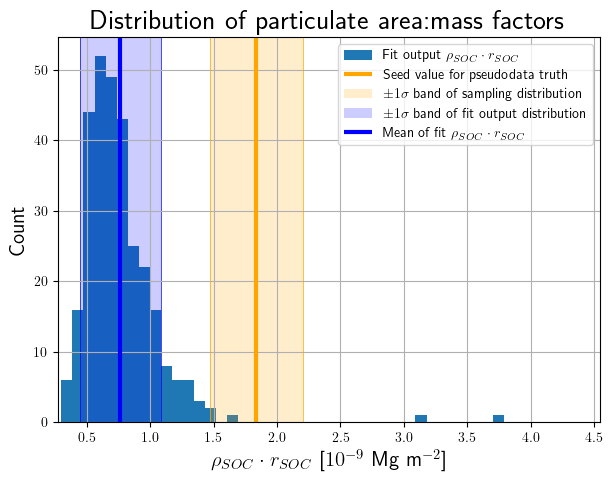

In [103]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

th = plt.hist(np.array(rrs),bins=40,zorder=0,label=r'Fit output $\rho_{SOC} \cdot r_{SOC}$')
#plt.vlines(rrs[0],ymin=0,ymax=30,color='orange')
plt.xlim([np.min(th[1])*0.9,np.max(th[1])*1.2])
plt.ylim([0,np.max(th[0])*1.05])
plt.grid()

plt.xlabel(r'$\rho_{SOC} \cdot r_{SOC}$ [$10^{-9}$ Mg m$^{-2}$]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Seed value for pseudodata truth',lw=3);
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.2,label=r'$\pm1\sigma$ band of sampling distribution'));


# Empirical average and variance are computed
avg = np.mean(np.array(rrs))
sd = np.sqrt(np.var(np.array(rrs)))
ax.add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="blue",alpha=0.2,label=r'$\pm1\sigma$ band of fit output distribution'));
plt.vlines(avg,ymin=0,ymax=np.max(th[0])*1.05,color='blue',label=r'Mean of fit $\rho_{SOC}\cdot r_{SOC}$',lw=3);
ax.vlines(trueSOCrr*0.8,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(trueSOCrr*1.2,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(avg-sd,ymin=0,ymax=np.max(th[0])*1.05,color='blue',lw=0.5,zorder=1);
ax.vlines(avg+sd,ymin=0,ymax=np.max(th[0])*1.05,color='blue',lw=0.5,zorder=1);

plt.legend(loc='best')

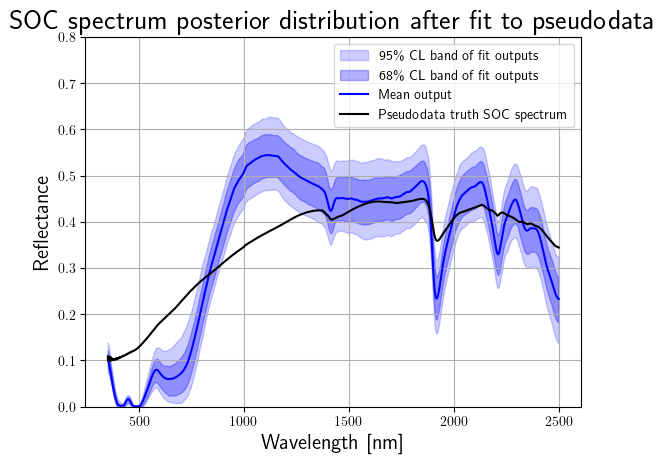

In [108]:
#plt.fill_between(XF,np.quantile(socspecs,0.99,axis=1),np.quantile(socspecs,0.01,axis=1),color='blue',alpha=0.1,label=r'99\% CL band')
plt.fill_between(XF,np.quantile(socspecs,0.95,axis=1),np.quantile(socspecs,0.05,axis=1),color='blue',alpha=0.2,label=r'95\% CL band of fit outputs')
plt.fill_between(XF,np.quantile(socspecs,0.84,axis=1),np.quantile(socspecs,0.16,axis=1),color='blue',alpha=0.3,label=r'68\% CL band of fit outputs')

#plt.plot(XF,np.mean(socspecs,axis=1), color='orange',lw=0.5, label=r'Mean of fit outputs');

plt.plot(XF,np.mean(socspecs,axis=1), color='blue', label=r'Mean output');
plt.plot(XF,seedFsoc, color='black', label=r'Pseudodata truth SOC spectrum');

plt.ylim([0.0,0.8])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'SOC spectrum posterior distribution after fit to pseudodata',fontsize=20)

plt.grid()
plt.legend(loc='best');

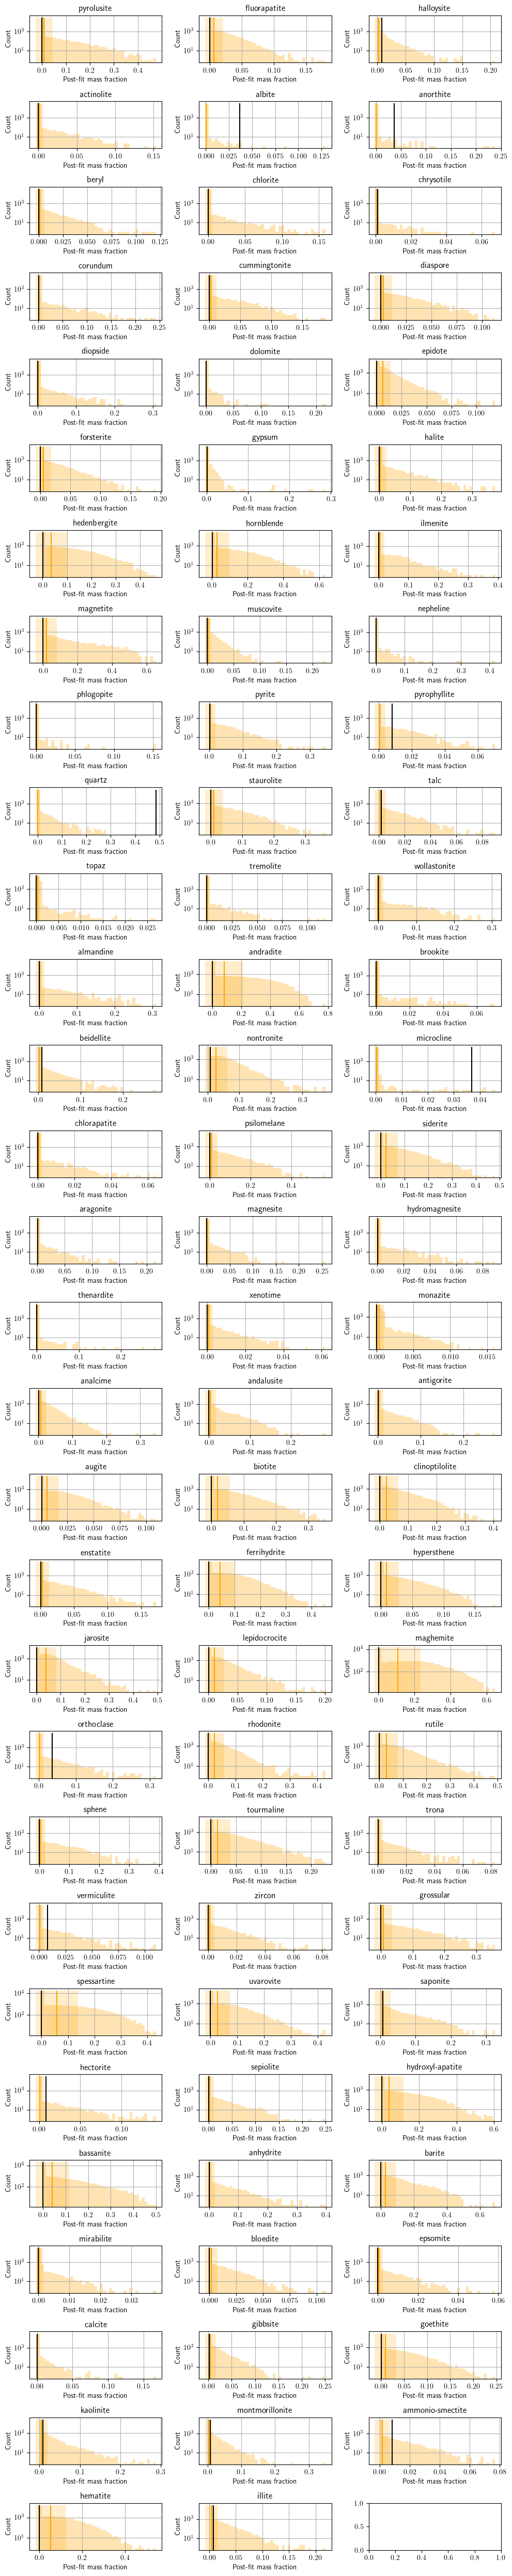

In [105]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in range(ms.shape[1]):

    col = index % 3
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(ms[:,iEndmember,:].flatten(),bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(ms[:,iEndmember,:].flatten())
    sd = np.sqrt(np.var(ms[:,iEndmember,:].flatten()))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()